# NFL Spread Predictive Model


## 0. Setup

This section defines the core libraries, helper functions, and global configuration used throughout the project. In particular, it introduces a reusable rolling-average function that enables pre-game feature construction without information leakage.

In [ ]:
import pandas as pd
import nflreadpy as nfl
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
from xgboost import plot_importance


In [ ]:
# Used to calculate the averages of a teams stats from the previous X amount of weeks to help model team momentum.

def rolling_averages(df,cols_to_roll,window):
    df = df.sort_values(['team','gameday'])
    grouped = df.groupby(['team','season'],group_keys = False)
    rolling_stats = grouped[cols_to_roll].rolling(window,closed = 'left',min_periods = 1).mean()
    rolling_stats = rolling_stats.reset_index(level = 0, drop = True)
    rolling_cols = [f"{c}_rolling" for c in cols_to_roll]
    df[rolling_cols] = rolling_stats.values
    return df

## 1. Data Loading

This section loads historical NFL team statistics and game schedules from nflreadpy, restricts the dataset to regular-season games, and standardizes team identifiers across seasons. Team-level schedule rows are constructed so that each observation corresponds to a single team in a single game, forming the foundation for feature engineering.

In [ ]:
team_stats = nfl.load_team_stats(list(range(2005,2026)))
team_stats = team_stats.to_pandas()
team_stats = team_stats[team_stats["season_type"] == "REG"]
schedules = nfl.load_schedules(list(range(2005,2026)))
schedules = schedules.to_pandas()
schedules = schedules[schedules["game_type"] == "REG"]

pd.set_option('display.max_columns',None)

schedules["gameday"] = pd.to_datetime(schedules["gameday"], errors = "coerce")

schedules = schedules[schedules["gameday"] < '2025-12-24']


In [ ]:
cols = [
    "game_id","season","week","gameday","weekday","result","spread_line","total_line","home_team","away_team","home_score","away_score"
]

sched = schedules[cols].copy()

In [ ]:
home = sched.rename( 
    columns = {
        "home_team":"team",
        "away_team":"opponent_team",
        "home_score":"points_for",
        "away_score":"points_against"
    }
).copy()
home["is_home"] = 1

away = sched.rename(
columns= {
    "away_team":"team",
    "home_team":"opponent_team",
    "away_score":"points_for",
    "home_score":"points_against"
}
    
).copy()
away["is_home"] = 0

full_sched = pd.concat([home,away],ignore_index = True)

In [ ]:
team_map = {
    'STL': 'LA',
    'SD':'LAC',
    'OAK':'LV'
}

team_stats['team'] = team_stats['team'].replace(team_map)
team_stats['opponent_team'] = team_stats['opponent_team'].replace(team_map)
full_sched['team'] = full_sched['team'].replace(team_map)
full_sched['opponent_team'] = full_sched['opponent_team'].replace(team_map)



## 2. Data Merge and Cleaning

Here, team statistics are merged with the constructed team-level schedules to align game outcomes, betting lines, and team performance metrics. Rows with incomplete outcomes are removed, and the dataset is sorted chronologically to ensure correct downstream rolling calculations.

In [ ]:
cols_updated = ['game_id',
 'season',
 'season_type',
 'week',
 'gameday',
 'weekday',
 'spread_line',
 'total_line',
 'team',
 'is_home',
 'points_for',
 'points_against',
 'result',
 'opponent_team',
 'completions',
 'attempts',
 'passing_yards',
 'passing_tds',
 'passing_interceptions',
 'sack_yards_lost',
 'sack_fumbles_lost',
 'passing_epa',
 'carries',
 'rushing_yards',
 'rushing_tds',
 'rushing_fumbles_lost',
 'rushing_epa',
 'receiving_fumbles_lost',
 'receiving_yards_after_catch',
 'special_teams_tds',
 'def_tackles_for_loss',
 'def_sacks',
 'def_qb_hits',
 'def_interceptions',
 'def_pass_defended',
 'def_tds',
 'def_fumbles',
 'def_safeties',
 'misc_yards',
 'penalties',
 'penalty_yards',
]

In [ ]:
merged_team_stats = team_stats.merge(full_sched, on = ['season','week','team','opponent_team'],how='left')[cols_updated]

In [ ]:
merged_team_stats = merged_team_stats.dropna(subset = ['points_for','points_against'])
merged_team_stats = merged_team_stats.sort_values(["season","week","team"]).reset_index(drop = True)

## 3. Base Feature Engineering

This section constructs core offensive and defensive performance metrics, including total yards, turnovers, yards per play, penalty rate, point differential, and EPA per play. These features capture fundamental aspects of team efficiency and discipline that are not directly observable from raw box-score statistics.

In [ ]:
merged_team_stats["total_yards"] = merged_team_stats["passing_yards"] + merged_team_stats["rushing_yards"]
merged_team_stats["total_off_td"] = merged_team_stats["passing_tds"] + merged_team_stats["rushing_tds"]
merged_team_stats["turnovers_lost"] = merged_team_stats["passing_interceptions"] + merged_team_stats["sack_fumbles_lost"] + merged_team_stats["rushing_fumbles_lost"] + merged_team_stats["receiving_fumbles_lost"]
merged_team_stats["defensive_turnovers"] = merged_team_stats["def_fumbles"] + merged_team_stats["def_interceptions"]


In [ ]:
merged_team_stats = merged_team_stats.rename(columns = {'result':'point_diff'})
merged_team_stats['yards_per_play'] = merged_team_stats['total_yards'] / (merged_team_stats["attempts"] + merged_team_stats["carries"])
merged_team_stats['penalty_rate'] = merged_team_stats['penalty_yards'] / (merged_team_stats['total_yards'] + 1)
merged_team_stats['point_diff'] = merged_team_stats['points_for'] - merged_team_stats['points_against']
merged_team_stats['total_plays'] = merged_team_stats['attempts'] + merged_team_stats['carries']


merged_team_stats['epa_per_play'] = (
    (merged_team_stats['passing_epa'] * merged_team_stats['attempts']) + 
    (merged_team_stats['rushing_epa'] * merged_team_stats['carries']) ) / ((merged_team_stats['attempts'] + merged_team_stats['carries']) + .00001)

## 4. Prior Season Features

To capture longer-term team strength and continuity, this section aggregates season-level performance metrics and shifts them forward by one season. These prior-season features provide additional signal early in the season when limited current-year data is available.

In [ ]:
season_team_summary = (merged_team_stats.groupby(['season','team'], as_index = False).agg(
    games_played = ('game_id','nunique'),
    sum_point_diff = ('point_diff','sum'),
    sum_passing_epa = ('passing_epa','sum'),
    sum_rushing_epa = ('rushing_epa','sum'),
    sum_total_yards = ('total_yards','sum'),
)
)

In [ ]:
season_team_summary['point_diff_per_game'] = season_team_summary['sum_point_diff'] / season_team_summary['games_played']
season_team_summary['passing_epa_per_game'] = season_team_summary['sum_passing_epa'] / season_team_summary['games_played']
season_team_summary['rushing_epa_per_game'] = season_team_summary['sum_rushing_epa'] / season_team_summary['games_played']
season_team_summary['yards_per_game'] = season_team_summary['sum_total_yards'] / season_team_summary['games_played']

In [ ]:
prev_features = season_team_summary.copy()
prev_features['season'] = season_team_summary['season'] + 1

In [ ]:
prev_features = prev_features.rename(columns = {
    'point_diff_per_game':'prev_point_diff_per_game',
    'passing_epa_per_game':'prev_passing_epa_per_game',
    'rushing_epa_per_game':'prev_rushing_epa_per_game',
    'yards_per_game':'prev_yards_per_game',
}
)

prev_features = prev_features[['season','team','prev_point_diff_per_game','prev_passing_epa_per_game','prev_rushing_epa_per_game','prev_yards_per_game']]

In [ ]:
merged_team_stats = merged_team_stats.merge(
    prev_features, 
    on = ['season','team'],
    how = 'left'
)

## 5. Rolling Features(Pre-game)

Rolling averages are computed using a three-game window to model short-term team momentum while avoiding lookahead bias. For Week 1 games, rolling values are initialized using prior-season ending statistics to prevent zero-information starts and maintain temporal consistency.

In [ ]:
rolling_targets = ['passing_epa',
 'rushing_epa',
 'total_yards',
 'total_off_td',
 'yards_per_play',
 'def_sacks',
 'def_qb_hits',
 'def_tds',
 'defensive_turnovers',
 'turnovers_lost',
 'penalty_rate',
 'point_diff',
 'points_for',
 'points_against',
 'epa_per_play']

In [ ]:
all_with_roll = rolling_averages(merged_team_stats,rolling_targets,3)

In [ ]:
rolling_cols = [f"{c}_rolling" for c in rolling_targets]

In [ ]:
end_of_season_roll =(
    all_with_roll.sort_values(['team','season','week'])
    .groupby(['team','season'],as_index = False).tail(1)[['team','season'] + rolling_cols])

In [ ]:
end_of_season_roll['season'] = end_of_season_roll['season'] + 1

In [ ]:
all_with_roll = all_with_roll.merge(
    end_of_season_roll, on = ['team','season'], how = 'left', suffixes = ("","_prev_season")
)

In [ ]:
week1_mask = all_with_roll['week'] == 1

for col in rolling_cols:
    all_with_roll.loc[week1_mask, col] = all_with_roll.loc[week1_mask, f"{col}_prev_season"]

## 6. Opponent Feature Merge and Synergy Columns

This section augments each observation with corresponding opponent rolling and prior-season metrics. Additional synergy features, such as offensive balance and explosiveness, are introduced to capture nonlinear interactions between offensive components.


In [ ]:
all_with_roll['off_balance_rolling'] = all_with_roll['passing_epa_rolling'] * all_with_roll['rushing_epa_rolling']
all_with_roll['explosiveness_rolling'] = all_with_roll['total_off_td_rolling'] / (all_with_roll['total_yards_rolling'] + 1)

synergy_cols = ['off_balance_rolling','explosiveness_rolling']

In [ ]:
team_cols = rolling_cols.copy()
prev_cols =['prev_point_diff_per_game','prev_passing_epa_per_game','prev_rushing_epa_per_game','prev_yards_per_game',]
team_cols.extend(prev_cols)
team_cols.extend(synergy_cols)

In [ ]:
team_lookup = all_with_roll[['season','week','team']+team_cols].copy()

In [ ]:
opp_lookup = team_lookup.rename(columns={"team": "opponent_team"}).copy()
for col in team_cols:
    opp_lookup[f"opp_{col}"] = opp_lookup[col]

opp_cols = ['season','week','opponent_team',] + [f"opp_{c}" for c in team_cols]
opp_lookup = opp_lookup[opp_cols]
all_with_roll = all_with_roll.merge(opp_lookup, on = ['season','week','opponent_team'], how = "left")

## 7. Matchup Feature Engineering

Matchup-specific features are created by computing differences, ratios, and nonlinear transformations between team and opponent metrics. These features explicitly model relative advantages between competing teams rather than absolute performance levels.

In [ ]:
diff_cols = ['passing_epa_rolling',
                'point_diff_rolling',
                'def_sacks_rolling',
                'points_for_rolling',
                'points_against_rolling',
                'prev_point_diff_per_game',
                'epa_per_play_rolling',
                ]

for col in diff_cols:
    all_with_roll[f"{col}_diff"] = all_with_roll[col] - all_with_roll[f"opp_{col}"]

In [ ]:
ratio_cols = ['passing_epa_rolling',
              'point_diff_rolling',
              'turnovers_lost_rolling',
              'def_sacks_rolling',
              'total_off_td_rolling',
              'points_against_rolling',
]

for col in ratio_cols:
    all_with_roll[f"{col}_ratio"] = all_with_roll[col] / (all_with_roll[f"opp_{col}"]+.00001)

In [ ]:
all_with_roll["yards_per_play_rolling_advantage"] = (all_with_roll['yards_per_play_rolling'] > all_with_roll['opp_yards_per_play_rolling']).astype(int)


In [ ]:
all_with_roll['passing_epa_power_rolling'] = (all_with_roll['passing_epa_rolling'] - all_with_roll['opp_passing_epa_rolling']) ** 2
all_with_roll['point_diff_power_rolling'] = (all_with_roll['point_diff_rolling'] - all_with_roll['opp_point_diff_rolling']) ** 2
all_with_roll['explosiveness_power_rolling'] = (all_with_roll['explosiveness_rolling'] - all_with_roll['opp_explosiveness_rolling']) ** 2


In [ ]:
core_features = ['spread_line',
 'total_line',
 'is_home',
 'passing_epa_rolling',
 'point_diff_rolling',
 'turnovers_lost_rolling',
 'points_against_rolling',
 'opp_turnovers_lost_rolling',
 'opp_point_diff_rolling',
 'passing_epa_rolling_diff',
 'point_diff_rolling_diff',
 'def_sacks_rolling_diff',
 'points_for_rolling_diff',
 'points_against_rolling_diff',
 'passing_epa_rolling_ratio',
 'point_diff_rolling_ratio',
 'turnovers_lost_rolling_ratio',
 'def_sacks_rolling_ratio',
 'total_off_td_rolling_ratio',
 'points_against_rolling_ratio',
 'yards_per_play_rolling_advantage',
 'off_balance_rolling',
 'passing_epa_power_rolling',
 'point_diff_power_rolling',
 'explosiveness_power_rolling',
 'prev_point_diff_per_game_diff',
 'epa_per_play_rolling',
 'opp_epa_per_play_rolling',
 'epa_per_play_rolling_diff']

## 8. Train, Validation, and Test Split

Train Split: 2005 Season to 2022 Season

Validation Split: 2022 Season to 2024 season

Test Split: 2024 Season to 12/24/2025

The dataset is split chronologically into training, validation, and test sets to preserve real-world forecasting conditions. Validation data is used exclusively for model selection and probability calibration, while the test set is held out for final out-of-sample evaluation.

In [ ]:
team_with_opp_train = all_with_roll[(all_with_roll['gameday'] >'2006-06-01') & (all_with_roll['gameday'] < '2022-06-01') ]
team_with_opp_val = all_with_roll[(all_with_roll['gameday'] > '2022-06-01') & (all_with_roll['gameday'] < '2024-06-01')]
team_with_opp_test = all_with_roll[(all_with_roll['gameday'] > '2024-06-01') & (all_with_roll['gameday'] < '2025-12-24')]

train = team_with_opp_train
val = team_with_opp_val
test = team_with_opp_test

X_train = train[core_features]
y_train = train['point_diff']

X_val = val[core_features]
y_val = val['point_diff']

X_test = test[core_features]

y_test = test['point_diff']

## 9. Baseline Model- Linear Regression

A linear regression model is fit as a baseline to establish reference performance and confirm that the engineered features contain predictive signal. This baseline provides context for evaluating the incremental value of more flexible nonlinear models.

In [ ]:
bad_idx = X_train[X_train.isna().any(axis = 1)].index

In [ ]:
X_train_clean = X_train.drop(index = bad_idx)
y_train_clean = y_train.drop(index = bad_idx)

In [ ]:
linreg = LinearRegression()

linreg.fit(X_train_clean,y_train_clean)
y_val_pred = linreg.predict(X_val)


In [ ]:
mae = mean_absolute_error(y_val,y_val_pred)
rmse = mean_squared_error(y_val,y_val_pred) ** .5
r2 = r2_score(y_val,y_val_pred)

mae,rmse,r2

## 10. Final Model - XGBoost Regressor

An XGBoost regression model is trained to predict margin of victory using the full feature set. This model is selected for its ability to capture nonlinear relationships and interactions while maintaining strong generalization performance on validation data.

In [ ]:
xgb = XGBRegressor(n_estimators = 1400,
                   learning_rate = .003020,
                   max_depth = 5,
                   subsample = .8,
                   min_child_weight = 1,
                   reg_lambda = 1,
                   reg_alpha = 0.3,
                   objective = "reg:squarederror",
                   random_state = 42

)
xgb.fit(X_train, y_train)

y_val_pred_xgb = xgb.predict(X_val)


In [ ]:
mae_xgb = mean_absolute_error(y_val,y_val_pred_xgb)
mse_xgb = mean_squared_error(y_val,y_val_pred_xgb) ** .5
r2_xgb = r2_score(y_val,y_val_pred_xgb)

mae_xgb,mse_xgb,r2_xgb

## 11. Edge Defiinition and Validation Diagnostics

Model predictions are transformed into betting edges by comparing predicted margins to market spread lines. This section defines home and away cover outcomes and establishes the core signal used for subsequent betting simulations.

In [ ]:
val_df = val.copy()
val_df = val_df[val_df['is_home'] == 1].copy()

val_df['home_margin'] = val_df['point_diff']


In [ ]:
val_df['home_cover'] = ((val_df['home_margin'] - val_df['spread_line']) > 0).astype(int)
val_df['push'] = ((val_df['home_margin'] - val_df['spread_line']) == 0).astype(int)

In [ ]:
val_df['pred_home_margin'] = xgb.predict(X_val.loc[val_df.index])

val_df['edge'] = val_df['pred_home_margin'] - val_df['spread_line']


## 12. Edge Bucketing

Edges are bucketed to explore the empirical relationship between model signal strength and realized outcomes. This exploratory analysis helps identify regions where the model exhibits directional consistency and motivates later calibration choices.

In [ ]:
bins = [-20,-10,-6,-4,-2.5,-1.5,0,1.5,2.5,4,6,10,20]

labels = ['< -10','-10 to -6','-6 to -4','-4 to -2.5','-2.5 to -1.5','-1.5 to 0',
          '0 to 1.5','1.5 to 2.5','2.5 to 4','4 to 6','6 to 10','> 10']

val_df["edge_bucket_explore"] = pd.cut(val_df['edge'], bins = bins, labels = labels)

In [ ]:
bucket_summary = (
    val_df.groupby('edge_bucket_explore').agg(
        games = ("edge","count"),
        avg_edge = ("edge","mean"),
        cover_rate = ("home_cover","mean"),
        avg_margin = ("home_margin","mean")
    )
)

bucket_summary

## 13. Calibration Edge - Win Probability


Validation data is used to empirically map model edges to away-cover probabilities using edge buckets and global shrinkage. This calibration step stabilizes probability estimates and enables principled fractional Kelly sizing without contaminating the test set.

In [ ]:
cal_df = val_df[val_df["edge"] < -1.0].copy()
cal_df = cal_df[cal_df['push']==0]

bins_c = [-10,-6,-4,-2.5,-1.0]
labels_c = ["-10 to -6","-6 to -4","-4 to -2.5","-2.5 to -1.0",]

val_df["edge_bucket"] = pd.cut(val_df['edge'], bins = bins_c, labels = labels_c, include_lowest = True)

In [ ]:
cal_df["edge_bucket"] = pd.cut(cal_df['edge'], bins = bins_c, labels = labels_c )
cal_df['away_cover'] = (cal_df["home_cover"] == 0).astype(int)


In [ ]:


calibration_table = (
    cal_df.groupby("edge_bucket").agg(
        games = ("edge","count"),
        away_cover_prob = ("away_cover","mean"),
        avg_edge = ("edge","mean")
    )
    .reset_index()
)

calibration_table

In [ ]:
val_df = val_df.merge(calibration_table[['edge_bucket','away_cover_prob']], on = 'edge_bucket',  how = 'left')

global_p = cal_df["away_cover"].mean()  
val_df["away_cover_prob"] = val_df["away_cover_prob"].fillna(global_p)

In [ ]:
cal_df_plot = cal_df.copy()
cal_df_plot['global_p'] = global_p

In [ ]:
cal_table = (
    cal_df_plot.groupby("edge_bucket")
       .agg(
           games=("edge", "count"),
           avg_edge=("edge", "mean"),
           away_cover_rate=("away_cover", "mean")
       )
       .reset_index()
)
cal_table

In [ ]:
plt.figure(figsize=(8,5))

# point sizes scaled by sample size
sizes = 20 + 3 * cal_table["games"]

plt.scatter(cal_table["avg_edge"], cal_table["away_cover_rate"], s=sizes)

# reference: global probability
plt.axhline(global_p, linestyle="--")

plt.xlabel("Average edge in bucket (pred_home_margin - spread)")
plt.ylabel("Empirical away cover rate")
plt.title("Validation calibration: edge → away cover rate")
plt.ylim(0, 1)
plt.show()

In [ ]:
N0 = 50  

cal_table["w"] = cal_table["games"] / (cal_table["games"] + N0)
cal_table["p_shrunk"] = cal_table["w"] * cal_table["away_cover_rate"] + (1 - cal_table["w"]) * global_p


In [ ]:
plt.figure(figsize=(8,5))

sizes = 20 + 3 * cal_table["games"]
plt.scatter(cal_table["avg_edge"], cal_table["away_cover_rate"], s=sizes, label="Empirical (bucket)")

plt.plot(cal_table["avg_edge"], cal_table["p_shrunk"], marker="o", label="Shrunk p used")

plt.axhline(global_p, linestyle="--", label="Global p")

plt.xlabel("Average edge in bucket")
plt.ylabel("Probability")
plt.title("Validation calibration: empirical vs shrunk probabilities")
plt.ylim(0, 1)
plt.legend()
plt.show()


## 14. Flat-stake Backtest

Flat-stake betting simulations are conducted on validation data to evaluate signal quality independent of bet sizing. Threshold-based results provide intuition about trade-offs between bet frequency, win rate, and expected profitability.

In [ ]:
payout = 100/110

In [ ]:
def flat_backtest_away(df,threshold):
    d = df.copy()

    d["bet"] = d["edge"] <= -threshold

    d["win"] = d["bet"] & (d["push"] == 0) & (d["home_cover"] == 0)
    d["loss"] = d["bet"] & (d["push"] == 0) & (d["home_cover"] == 1)

    d["units"] = 0.0
    d.loc[d["win"], "units"] = payout
    d.loc[d["loss"], "units"] = -1.0


    bets = int(d["bet"].sum())
    wins = int(d["win"].sum())
    losses = int(d["loss"].sum())

    return {
        "threshold": threshold,
        "bets": bets,
        "win_rate_no_push": wins / (wins + losses) if (wins + losses) > 0 else None,
        "units": float(d["units"].sum()),
        "units_per_bet": float(d.loc[d["bet"], "units"].mean()) if bets > 0 else None}

In [ ]:
thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
flat_results_val = pd.DataFrame([flat_backtest_away(val_df, t) for t in thresholds])
flat_results_val

In [ ]:
BEST_THRESHOLD = 1.0

## 15. Kelly Criterion Sized Betting

Fractional Kelly sizing is applied using calibrated probabilities to simulate capital allocation under realistic risk constraints. Bet sizes are capped to limit downside exposure from probability error and short-run variance.

In [ ]:
PAYOUT = 100/110
decimal_odds = 1 + PAYOUT

In [ ]:
BEST_THRESHOLD = 1.0
KELLY_MULTI = .33
MAX_FRAC = .02
BANKROLL0 = 1.0

In [ ]:
def kelly_fraction(p,d = decimal_odds):
    return (p * d - 1) / (d - 1)

In [177]:
def kelly_backtest_away(df, threshold = BEST_THRESHOLD, kelly_multi = KELLY_MULTI, max_frac = MAX_FRAC, bankroll = BANKROLL0 ):
    d = df.copy().sort_values(['gameday','game_id']).reset_index(drop = True)

    d["bet"] = (d["edge"] <= -threshold) & d["away_cover_prob"].notna()

    d["p"] = d["away_cover_prob"]
    d["f_raw"] = kelly_fraction(d["p"])
    d["f"] = kelly_multi * d["f_raw"]

    d["bet"] = d["bet"] & (d["f"] > 0)
    d.loc[d["bet"], "f"] = d.loc[d["bet"], "f"].clip(upper=max_frac)
    bankroll1 = bankroll
    bankroll_path = []

    for _, r in d.iterrows():
        if not r["bet"]:
            bankroll_path.append(bankroll1)
            continue

        stake = bankroll1 * float(r["f"])

        if r["push"] == 1:
            bankroll1 = bankroll1
        elif r["home_cover"] == 0:
            bankroll1 += stake * PAYOUT
        else:
            bankroll1 -= stake

        bankroll_path.append(bankroll1)

    d["bankroll"] = bankroll_path

    bets = int(d["bet"].sum())
    final_bankroll = float(d["bankroll"].iloc[-1])
    profit_units = final_bankroll - bankroll

    return {
        "threshold": threshold,
        "kelly_mult": kelly_multi,
        "max_frac": max_frac,
        "bets": bets,
        "final_bankroll": final_bankroll,
        "profit_units": profit_units,
    }, d


In [182]:
kelly_summary_val, kelly_curve_val = kelly_backtest_away(
    val_df,
    threshold=1.0,
    kelly_multi=.33,
    max_frac=0.02,
    bankroll=1.0
)

kelly_summary_val

{'threshold': 1.0,
 'kelly_mult': 0.33,
 'max_frac': 0.02,
 'bets': 148,
 'final_bankroll': 1.2325871000451578,
 'profit_units': 0.2325871000451578}

## 16. Fractional Kelly on Test Data


The calibrated model and fractional Kelly sizing rules are applied to the held-out test set. Expected and realized performance are compared directly to assess whether the estimated edge persists out of sample.

In [151]:
test_df = test.copy()
test_df = test_df[test_df["is_home"] == 1].copy()

test_df["home_margin"] = test_df["point_diff"]
test_df["home_cover"] = ((test_df["home_margin"] - test_df["spread_line"]) > 0).astype(int)
test_df["push"] = ((test_df["home_margin"] - test_df["spread_line"]) == 0).astype(int)

X_test = test_df[core_features]
test_df["pred_home_margin"] = xgb.predict(X_test)

test_df["edge"] = test_df["pred_home_margin"] - test_df["spread_line"]

In [152]:
test_df["edge_bucket"] = pd.cut(
    test_df["edge"],
    bins=bins_c,
    labels=labels_c,
    include_lowest=True
)


In [153]:
test_df = test_df.merge(
    calibration_table[["edge_bucket", "away_cover_prob"]],
    on="edge_bucket",
    how="left"
)

global_p = cal_df["away_cover"].mean()
test_df["away_cover_prob"] = test_df["away_cover_prob"].fillna(global_p)


In [186]:
kelly_summary_test, kelly_curve_test = kelly_backtest_away(
    test_df,
    threshold=1.0,
    kelly_multi=0.33,
    max_frac=0.02,
    bankroll=1.0
)

kelly_summary_test

{'threshold': 1.0,
 'kelly_mult': 0.33,
 'max_frac': 0.02,
 'bets': 133,
 'final_bankroll': 1.0912830989709108,
 'profit_units': 0.0912830989709108}

In [155]:
d = kelly_curve_test.copy()

d['realized_units'] = 0.0
d.loc[(d["bet"]) & (d["push"] == 0) & (d["home_cover"] == 0), "realized_units"] = PAYOUT
d.loc[(d["bet"]) & (d["push"] == 0) & (d["home_cover"] == 1), "realized_units"] = -1.0

In [156]:
d["expected_units"] = 0.0
bet_mask = (d["bet"]) & (d["push"] == 0)

d.loc[bet_mask, "expected_units"] = (
    d.loc[bet_mask, "away_cover_prob"] * PAYOUT
    - (1 - d.loc[bet_mask, "away_cover_prob"])
)

In [157]:
d["cum_realized_units"] = d["realized_units"].cumsum()
d["cum_expected_units"] = d["expected_units"].cumsum()

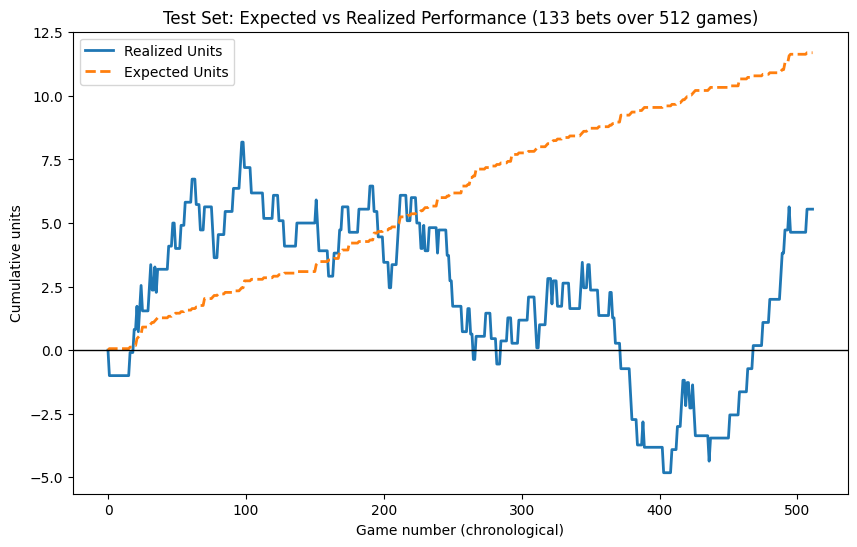

In [158]:
plt.figure(figsize=(10,6))

plt.plot(d["cum_realized_units"], label="Realized Units", linewidth=2)
plt.plot(d["cum_expected_units"], label="Expected Units", linestyle="--", linewidth=2)

plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Game number (chronological)")
plt.ylabel("Cumulative units")
plt.title("Test Set: Expected vs Realized Performance (133 bets over 512 games)")
plt.legend()
plt.show()


## 17. Risk Analysis

This section evaluates downside risk through flat-unit drawdowns and Kelly-sized bankroll drawdowns. Both magnitude and duration of drawdowns are examined to assess survivability and practical deployability.

In [159]:
d['running_max'] = d['cum_realized_units'].cummax()
d['drawdown'] =  d['cum_realized_units'] - d['running_max']

In [160]:
max_drawdown = d['drawdown'].min()
max_drawdown

np.float64(-12.999999999999998)

In [161]:
dd_end_idx = d['drawdown'].idxmin()
dd_start_idx = d.loc[:dd_end_idx, 'cum_realized_units'].idxmax()

dd_start_idx,dd_end_idx, 

(97, 403)

In [162]:
d.loc[[dd_start_idx, dd_end_idx], ["cum_realized_units", "running_max", "drawdown"]]


,cum_realized_units,running_max,drawdown
97,8.181818,8.181818,0.0
403,-4.818182,8.181818,-13.0


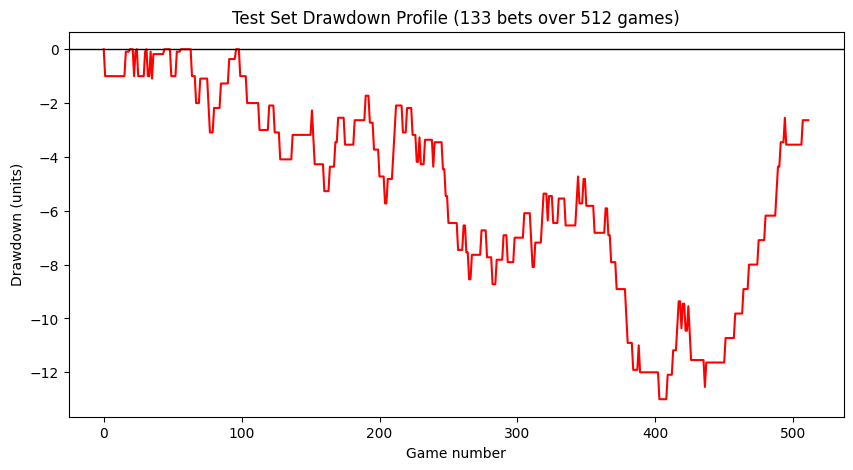

In [163]:
plt.figure(figsize=(10,5))
plt.plot(d["drawdown"], color="red")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Game number")
plt.ylabel("Drawdown (units)")
plt.title("Test Set Drawdown Profile (133 bets over 512 games)")
plt.show()

In [164]:
risk_summary = {
    "bets": int(d["bet"].sum()),
    "final_units": d["cum_realized_units"].iloc[-1],
    "max_drawdown_units": max_drawdown,
    "max_drawdown_per_bet": max_drawdown / d["bet"].sum(),
}

risk_summary

{'bets': 133,
 'final_units': np.float64(5.545454545454548),
 'max_drawdown_units': np.float64(-12.999999999999998),
 'max_drawdown_per_bet': np.float64(-0.09774436090225562)}

In [165]:
d['running_max_bankroll'] = d['bankroll'].cummax()
d["bankroll_drawdown"] = d["bankroll"] / d["running_max_bankroll"] - 1

max_bankroll_dd = d["bankroll_drawdown"].min()
max_bankroll_dd

np.float64(-0.23974831272990738)

In [190]:
kelly_summary_test, max_bankroll_dd

({'threshold': 1.0,
  'kelly_mult': 0.33,
  'max_frac': 0.02,
  'bets': 133,
  'final_bankroll': 1.0912830989709108,
  'profit_units': 0.0912830989709108},
 np.float64(-0.23974831272990738))

## 18. Results and Limitations



### Results

On the held-out test set, the model demonstrated **positive expected value**, as measured using validation-calibrated probabilities and flat-unit expected value. Cumulative expected units increased steadily across the test period, indicating that the model’s estimated edge generalized out of sample rather than arising from overfitting or favorable variance.

Realized performance, however, was substantially more volatile. While the strategy finished the test period with positive realized returns, the path to profitability involved extended drawdowns and prolonged periods of underperformance relative to expectation. This divergence between expected and realized outcomes is consistent with the small magnitude of the edge and the high variance characteristic of NFL spread betting markets. Over the course of the test period, an **ROI of 9.1%** was achieved proving profitability in a volatile environment.

All capital deployment was performed using a **conservative fractional Kelly sizing approach**, rather than flat staking. Specifically, position sizes were set to a fixed fraction of the full Kelly criterion and capped on a per-bet basis. This approach allowed bet sizes to scale with estimated edge strength while limiting downside risk from probability miscalibration and short-run variance. Under this sizing regime, the strategy remained solvent throughout the test period and avoided catastrophic losses that would likely occur under full Kelly sizing.

Risk analysis further contextualized these results. The maximum flat-unit drawdown on the test set was approximately **13 units**, reflecting the volatility of outcomes independent of staking. When evaluated in terms of capital, the maximum fractional Kelly bankroll drawdown was approximately **23%**, occurring over an extended calendar period. These magnitudes are consistent with a small but persistent edge in an efficient market and underscore the psychological and financial demands of deploying such a strategy in practice.

---

### Limitations

Several important limitations should be noted.

First, the model’s edge is **modest**, reflecting the high efficiency of NFL betting markets. As a result, realized outcomes are dominated by variance over short and medium horizons, and profitability cannot be reliably inferred from isolated seasons or limited samples. Positive expected value does not imply smooth or monotonic capital growth.

Second, probability calibration relies on **empirical edge bucketing with global shrinkage**, which stabilizes estimates but introduces uncertainty in sparsely populated edge regions. Kelly-based strategies are particularly sensitive to probability error, making conservative fractional sizing essential.

Third, the test set represents a **single realization** of outcomes. While expected value remained positive, alternative realizations could plausibly produce materially different realized profits or drawdowns. Results should therefore be interpreted probabilistically rather than deterministically.

Finally, the analysis abstracts away from **real-world market frictions**, including line shopping, timing effects, betting limits, and correlated exposures across games. These factors may materially affect deployability and scalability in practice and are not captured in the present backtest.

---

### Conclusion

Overall, the results indicate that the model identifies a **small but persistent** out-of-sample edge in NFL spreads that survives rigorous train–validation–test evaluation. While realized outcomes are subject to substantial variance and extended drawdowns, expected value remains **consistently positive**, suggesting that the underlying signal is stable rather than incidental.

Importantly, the analysis demonstrates that this edge can be deployed responsibly through conservative fractional Kelly sizing, allowing capital to grow over time while remaining resilient to inevitable periods of underperformance. The observed drawdowns, while meaningful, are consistent with theoretical expectations for a strategy operating in a highly efficient market and do not undermine the long-run viability of the approach.

Taken together, these results suggest that disciplined modeling, careful calibration, and robust risk management can produce actionable insights even in competitive betting environments. With continued refinement to feature engineering, probability calibration, and market-aware constraints, this framework provides a strong foundation for future improvements and more scalable applications.
